In [1]:
# https://python-graph-gallery.com/web-stacked-line-chart-with-labels/

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from common import (
    read_workout_dfs, 
    load_racing_sans_one_font,
    load_roboto_condensed_font,
    MY_COLORS, 
)


In [3]:
title_font = load_racing_sans_one_font()
body_font = load_roboto_condensed_font()

colors = [
    MY_COLORS['Bright Orange'], 
    MY_COLORS['Slightly Darker Orange'], 
    MY_COLORS['Vivid Red-Orange'], 
    MY_COLORS['Medium Midnight Blue'], 
    MY_COLORS['Dark Midnight Blue'], 
]

In [4]:
dfs = read_workout_dfs()

In [5]:
df_months = []
for year, df in dfs.items():
    df["year"] = year
    df["month"] = df["WorkoutDay"].apply(lambda date: date.split("-")[1])
    df["week_number"] = pd.to_datetime(df["WorkoutDay"]).apply(lambda date: date.weekofyear)

    df["week_date"] = pd.to_datetime(df["year"].astype(str) + "-W" + df["week_number"].astype(str) + "-1", format="%G-W%V-%w")
    df["month_date"] = pd.to_datetime(df["year"].astype(str) + "-" + df["month"].astype(str) + "-1", format="%Y-%m-%d")
    groupby_cols = ["month_date", "year"]

    if year == 2021:
        df = df[df["month"].isin(["11", "12"])]
    elif year == 2024:
        df = df[df["month"].isin(["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11"])]
    df_stacked = pd.melt(df, id_vars=groupby_cols, value_vars=['HRZone1Minutes', 'HRZone2Minutes', 'HRZone3Minutes', 'HRZone4Minutes', 'HRZone5Minutes'], var_name="hr_zone", value_name="total_time")
    df_stacked = df_stacked.groupby(groupby_cols + ["hr_zone"], as_index=False).agg({"total_time": "sum"})
    df_months.append(df_stacked)

df_months = pd.concat(df_months).reset_index(drop=True)

df_pivot = df_months.pivot(index=groupby_cols[0], columns="hr_zone", values="total_time")

/tmp/ipykernel_25114/981667774.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([


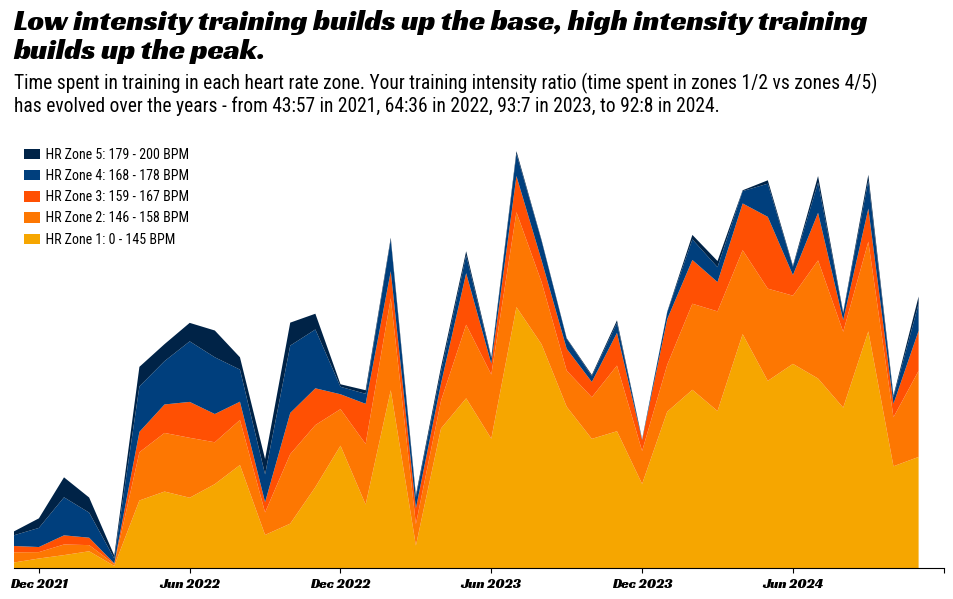

In [17]:
x_values = df_pivot.index.map(lambda date: pd.to_datetime(date).year + pd.to_datetime(date).month / 12)

plt.figure(figsize=(12, 6))
plt.stackplot(
    x_values, 
    df_pivot.values.T,
    labels=df_pivot.columns,
    colors=colors)
plt.text(2021.91666667, 2400,
         'Low intensity training builds up the base, high intensity training \nbuilds up the peak.', 
         fontsize=21,
         font=title_font)
low_zones = ["HRZone1Minutes", "HRZone2Minutes"]
high_zones = ["HRZone4Minutes", "HRZone5Minutes"]

def calc_ratio(year):
    year_data = df_months[df_months["year"]==year]
    low = year_data[year_data["hr_zone"].isin(low_zones)]["total_time"].sum()
    high = year_data[year_data["hr_zone"].isin(high_zones)]["total_time"].sum()
    total = low + high  # Only consider low and high zones for the total
    return f"{round(100 * low/total)}:{round(100 * high/total)}"

plt.text(2021.91666667, 2150,
         'Time spent in training in each heart rate zone. Your training intensity ratio (time spent in zones 1/2 vs zones 4/5)\n' +
         f'has evolved over the years - from {calc_ratio(2021)} in 2021, {calc_ratio(2022)} in 2022, {calc_ratio(2023)} in 2023, to {calc_ratio(2024)} in 2024.',
         fontsize=14,
         font=body_font)

ax = plt.gca()

def add_annotations_year(year):
    y_end = df_months[df_months["year"] == year]["total_time"].sum()
    # Add line 
    ax.plot([year, year], # x-axis position
            [0, y_end*1.05], # y-axis position (*1.05 is used to make a it little bit longer)
            color='black', # Color
            linewidth=1) # Width of the line
    
    # Add a point at the top of the line
    ax.plot(year, # x-axis position
            y_end*1.05, # y-axis position (*1.05 is used to make a it little bit longer)
            marker='o', # Style of the point
            markersize=5, # Size of the point
            color='black') # Color

# Create legend text in top left
col_to_annotation = {
    "HRZone1Minutes": "HR Zone 1: 0 - 145 BPM", 
    "HRZone2Minutes": "HR Zone 2: 146 - 158 BPM", 
    "HRZone3Minutes": "HR Zone 3: 159 - 167 BPM", 
    "HRZone4Minutes": "HR Zone 4: 168 - 178 BPM", 
    "HRZone5Minutes": "HR Zone 5: 179 - 200 BPM",
}

legend_y = 1950
rect_width = 20  # Width of the rectangle in data coordinates
rect_height = 50  # Height of the rectangle in data coordinates

for hr_zone, color in reversed(list(zip(df_pivot.columns, colors))):
    # Add colored rectangle
    rect = plt.Rectangle((2021.95, legend_y - rect_height/2), 
                        rect_width/365, rect_height,  # Convert width to year units
                        facecolor=color,
                        edgecolor='none')
    ax.add_patch(rect)
    
    # Add text after rectangle
    plt.text(2022.0, legend_y, "  " + col_to_annotation[hr_zone],  # Added spacing with "  "
             ha='left', va='center', fontsize=10,
             font=body_font, color='black')  # Changed text color to black for better readability
    
    legend_y -= 100

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.tick_params(left=False, labelleft=False)

ax.set_ylim(0, df_pivot.iloc[-1].cumsum().max() * 1.7)
ax.set_xlim(2021.91666667, 2025.0)
ax.set_xticklabels([
    "",
    "Dec 2021",
    "Jun 2022",
    "Dec 2022",
    "Jun 2023",
    "Dec 2023",
    "Jun 2024"
], fontsize=12, font=title_font)

plt.savefig('../figures/stacked_linechart.png', dpi=500, bbox_inches='tight')
plt.show()